In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_text, plot_tree

In [3]:
# Get data type of each column
def analyzeDataTypes(df):
    continuous_vars = []
    categorical_vars = []
    for column in df.columns:
        if df[column].dtype == 'object':
            categorical_vars.append(column)
        else:
            continuous_vars.append(column)
    return continuous_vars, categorical_vars

In [4]:
# Get data ready and separate X and Y
def prepareData(df):
    df = df.dropna()
    df = df.drop_duplicates()
    X = df.drop('NObeyesdad', axis=1)
    Y = df['NObeyesdad']
    return X, Y

In [5]:
# Preprocessing data with One-hot Encoding
def preprocessingOneHotEncoding(df, variables):
    if 'NObeyesdad' in variables:
        variables.remove('NObeyesdad')
    df_train = pd.get_dummies(df, columns=variables)
    # Eliminate multicollinearity
    df_train.drop('Gender_Female', axis=1, inplace=True)
    df_train.drop('family_history_with_overweight_yes', axis=1, inplace=True)
    df_train.drop('FAVC_no', axis=1, inplace=True)
    df_train.drop('SMOKE_yes', axis=1, inplace=True)
    df_train.drop('SCC_yes', axis=1, inplace=True)
    return df_train

In [6]:
# Preprocessing data with label encoder
def preprocessingWithLabelEncoder(df, variables):
    if 'NObeyesdad' in variables:
        variables.remove('NObeyesdad')
    le = LabelEncoder()
    for column in variables:
        df[column] = le.fit_transform(df[column])
    return df

In [7]:
# Training the model with Decision Tree Classifier
def trainModelDT(X_train, y_train):
    clf = Pipeline([
        # Standarize the data and train the model
        ('scaler', StandardScaler()),
        ('clf', tree.DecisionTreeClassifier(max_depth=30, min_samples_split=5, random_state=42))
    ])
    param_grid = {
        'clf__max_depth': [10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }
    clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=3)
    clf.fit(X_train, y_train)
    return clf
    


In [8]:
# Training the model with Random Forest
def trainModelRF (X_train, y_train):
    # Standarize the data and train the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ])

    # Define the parameter grid for Grid Search
    param_grid = {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }

    # Initialize Grid Search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search


In [11]:
""" Main function """
# Preprocessing data
# Load the data
df = pd.read_csv('../data/train.csv')
df = df.drop('id', axis=1)
continuous_vars, categorical_vars = analyzeDataTypes(df)
df.head()



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [12]:
# Preprocessing with variables
df_ohe = preprocessingOneHotEncoding(df, categorical_vars)
X_ohe, Y_ohe = prepareData(df_ohe)
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, Y_ohe, test_size=0.2, random_state=42)

# Preprocessing with label encoder
df_encoder = preprocessingWithLabelEncoder(df, categorical_vars)
X_encoder, Y_encoder = prepareData(df_encoder)
X_train_encoder, X_test_encoder, y_train_encoder, y_test_encoder = train_test_split(X_encoder, Y_encoder, test_size=0.2, random_state=42)

In [20]:
# Train Decision Trees
X_train_random_ohe = X_train_ohe.copy()
X_train_random_ohe["RANDOM"] = np.random.RandomState(42).randn(X_train_ohe.shape[0])

dt_ohe = trainModelDT(X_train_random_ohe, y_train_ohe)
# y_pred_dt_ohe = dt_ohe.predict(X_test_ohe)



X_train_random_enc = X_train_encoder.copy()
X_train_random_enc["RANDOM"] = np.random.RandomState(42).randn(X_train_encoder.shape[0])

dt_encoder = trainModelDT(X_train_random_enc, y_train_encoder)
# y_pred_dt_encoder = dt_encoder.predict(X_test_encoder)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [15]:
# Train Random Forest
rf_ohe = trainModelRF(X_train_random_ohe, y_train_ohe)
# y_pred_rf_ohe = rf_ohe.predict(X_test_ohe)

rf_encoder = trainModelRF(X_train_random_enc, y_train_encoder)
# y_pred_rf_encoder = rf_encoder.predict(X_test_encoder)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [24]:
import joblib

# Save the trained model to a file

joblib.dump(dt_ohe, 'DT_OHE_FI1_model.pkl')
joblib.dump(dt_encoder, 'DT_ENC_FI1.pkl')
joblib.dump(rf_ohe, 'RF_OHE_FI1_model.pkl')
joblib.dump(rf_encoder, 'RF_ENC_FI1_model.pkl')

# Load the model from the file
loaded_clf = joblib.load('random_forest_model.pkl')

# Verify the loaded model
print(f"Model loaded successfully: {loaded_clf}")

['RF_ENC_FI1_model.pkl']

In [22]:
treeOHE = dt_ohe.best_estimator_.named_steps['clf']

# # Feature Importance
dt_feature_importances = pd.DataFrame(treeOHE.feature_importances_, index=X_train_random_ohe.columns, columns=['importance']).sort_values('importance', ascending=False)
rf_feature_importances = pd.DataFrame(rf_ohe.best_estimator_.named_steps['clf'].feature_importances_, index=X_train_random_ohe.columns, columns=['importance']).sort_values('importance', ascending=False)


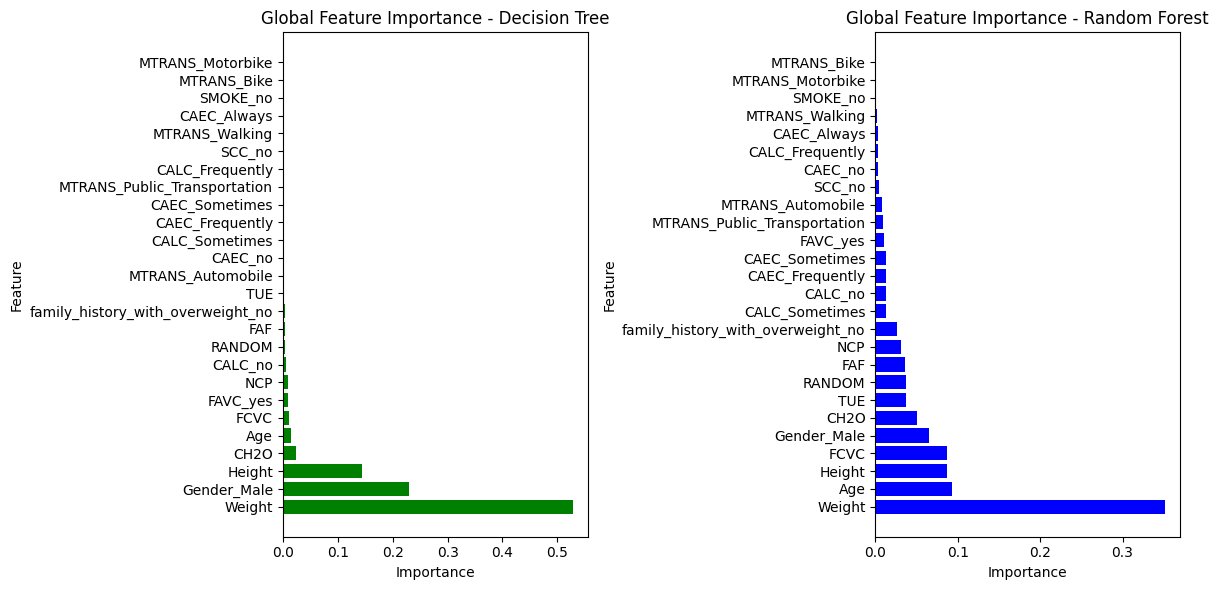

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot feature importance for Decision Tree
axes[0].barh(dt_feature_importances.index, dt_feature_importances['importance'], color='green')
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")
axes[0].set_title("Global Feature Importance - Decision Tree")

# Plot feature importance for Random Forest
axes[1].barh(rf_feature_importances.index, rf_feature_importances['importance'], color='blue')
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("Feature")
axes[1].set_title("Global Feature Importance - Random Forest")

plt.tight_layout()
plt.show()

According to the decision and random forest with a RANDOM generator. The important features are.

Decision Trees:
CALC, NCP, FAVC, FCVC, Age, CH20, Height, Gender, Weight

Random Forest:
TUE, FCVC, Age, CH20, Height, Gender, Weight

- Six features stay consistent
- Transportation and Smoking does not represent importance during classification

_Finding: Eliminate SMOKE and MTRANS to check improvement_

In [ ]:
#  Permutation Feature Importance
from sklearn.inspection import permutation_importance


result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_importances = result.importances_mean
perm_std = result.importances_std
sorted_idx = perm_importances.argsort()
feature_names = X_test.columns

pd.DataFrame({'Importance': perm_importances, 'Std': perm_std}, index=feature_names[sorted_idx]).sort_values('Importance',ascending=True)